In [2]:
import os

import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)
import warnings
warnings.filterwarnings('ignore')
from stanify.calibrator.visualizer import plot_sbc_ecdf, plot_sbc_histograms, plot_recovery, plot_posterior_2d

##  developing model families using visual diagnostics and numeric summaries
If you run the user interface code which states input and output format as below, it creates specific model, data, plot (two `.stan`, two `.nc files, multiple plots) in three folders. With minimal number of clicks, your model quality can be inspected. This aim of this vignette is to inspect how given the two outputs (model and data) can be analyzed for your next move.

keyword: simulation-based calibration, pair plots, divergence, InferenceData

<div>
<img src="../vensim_models/inventory/inven_1est_invenadjtime.png" width="800"/>
</div>

## user interface

In [ ]:
precision ={
    "S": 1, # # of draws from prior
    "M": 1000, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 200, # # of observation
    "R": 1 # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names" : ["adj_mat_push_frac1", "adj_mat_push_frac2"], #, "adj_mat_push_frac3", "ss2p_frac4"],
    "hier_est_param_names": [],
    "target_simulated_vector_names" : ["stocked_pping", "stocked_ping"],
    "driving_vector_names" : ["exog_demand", "process_noise_uniform_driving"],
    "model_name": "hier2_2est"
}
init_order = 100
# driving data
numeric = {
        "exog_demand": np.sin(np.arange(0, precision['N'])*10) * init_order * .5 + init_order,
        "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size=precision['N']),
        'process_noise_scale': 1
}
# TODO auto real dataFunc__exog_demand(0, time_saveper) * (1 / 1 / 3 + 1 / 1 / 2)
prior = {
    #("adj_mat_pull_frac3", "normal", 1/2.0, 1/2.0 *.1, 0),
    ("adj_mat_push_frac1", "normal", 1/4, 1/4.0 *.1, 0),
    ("adj_mat_push_frac2", "normal", 1/8, 1/8.0 *.1, 0),
    ("m_noise_scale", "normal", init_order * .1, init_order * .01, 0)
}

output_format = dict(
    prior_predictive=["stocked_pping_obs", "stocked_ping_obs"],
    posterior_predictive=["stocked_pping_obs_post", "stocked_ping_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'stocked_pping': ["time"],
        'stocked_ping': ["time"],
        "stocked_pping_obs": ["time"],
        "stocked_ping_obs": ["time"],
        'process_noise': ["time"],
    }
)

We load produced data for plotting. Please refer to the end of this document for model (stan code) and data structure which is Stanify's main contribution, but not the scope here.

`data2draws` have four groups: `posterior`, `prior_predictive`, `log_likelihood`, `samp_stats`, `observed_data`. First click the arrow below to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `posterior` group, observed vector (adding measurement noise on target simulated vector posterior) for `osberved_data` group, loglikelihood of each posterior sample for `log_likelihood`, lp, acceptance_rate, tree_depth, energy (HMC alg.parameters) `sample_stats_prior` group)

In [ ]:
model_name = "2hier_s_asy_osc_S1N40Q2P4H0R1_M1000_ps0.1"
sbc = az.from_netcdf(f"data/{model_name}/sbc_4est_pnoise0.1.nc")

#overlay with `color = (hierarchy)`,
#overlay with `color = (prior_draw, hierarchy)`,
#facet over hierarcy (sbuplot)and color by prior_braw
#could we put prey_obs and predator_obs in one plot?

In [ ]:
sbc

In [ ]:
sbc.sample_stats_prior

In [ ]:

output_format = dict(
    prior_predictive=["prey_obs", "predator_obs"],
    posterior_predictive=["prey_obs_post", "predator_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'prey': ["time"],
        'predator': ["time"],
        'process_noise': ["time"],
        "prey_obs": ["time"],
        "predator_obs": ["time"],
        "prey_obs_post": ["time"],
        "predator_obs_post": ["time"],
    }
)
for obs_name in output_format['prior_predictive']:
    sbc.observed_data[obs_name].plot(hue='prior_draw', row='region', x='time', figsize = (30,20))

In [ ]:
sbc.observed_data['prey_obs'].plot(hue = 'prior_draw', row = 'region', x = 'time') # left out coordinate (can have nonindex coordinate, second after start but wish to plot by date)

In [ ]:
sbc.posterior_predictive

In [ ]:
figsize = (30, 15)
for obs_name in output_format['prior_predictive']:
    sbc.observed_data[obs_name].plot(hue='prior_draw', x='time',  alpha=.3, figsize = figsize)
    sbc.posterior_predictive[f'{obs_name}_post'].mean(['draw', 'chain']).plot(hue='prior_draw', x='time',alpha=.6, linestyle='dotted', figsize = figsize)

In [ ]:
for obs_name in output_format['prior_predictive']:
    fig, axes = plt.subplots(precision['R'], 1, figsize=(30, 20))
    for r, ax in zip(range(precision['R']), axes):
        sbc_aux = sbc.sel(region=r)
        sbc_aux.observed_data[obs_name].plot(hue='prior_draw', x='time', ax=ax, alpha=.3)
        sbc_aux.posterior_predictive[f'{obs_name}_post'].mean(['draw', 'chain']).plot(hue='prior_draw', x='time', ax=ax, alpha=.6, linestyle='dotted')

In [ ]:
sbc.observed_data

In [ ]:
precision['R'] = 3

In [ ]:
# same color for 10 * [4 * 25].mean('chain', 'draw') = 1000? for observed data and
fig, ax = plt.subplots(3, 1)
sbc.observed_data['prey_obs'].plot(hue = 'prior_draw', row = 'region', x = 'time', ax = ax,)
sbc.posterior_predictive['prey_obs'].mean(['draw', 'chain']).plot(hue = 'prior_draw', row = 'region', x = 'time', ax = ax,)

In [ ]:
sbc

In [ ]:
sbc.observed_data.dims

In [ ]:
sbc.posterior_predictive.dims

In [ ]:
fig, axes = plt.subplots(precision['R'],1, figsize = (30, 20))
for r, ax in zip(range(precision['R']), axes):
    sbc_aux = sbc.sel(region = r)
    sbc_aux.observed_data['prey_obs'].plot(hue = 'prior_draw',x = 'time', ax = ax, alpha= .3)
    sbc_aux.posterior_predictive['prey_obs_post'].mean(['draw', 'chain']).plot(hue = 'prior_draw', x = 'time', ax = ax, alpha= .6, linestyle = 'dotted')

In [ ]:
sbc.posterior

In [ ]:
model_name2 = "prey_predator_S10N40Q2R3"
sbc2 = az.from_netcdf(f"data/{model_name2}/sbc_2est_mnoise0.nc")

In [ ]:
"az.plot_ppc(sbc, data_pairs={'predator_obs':'predator_obs_post', 'prey_obs':'prey_obs_post'}, flatten = [], kind = 'scatter', labeller=az.labels.DimCoordLabeller());
# labeller shows xlabel
# kind = scatter (few points)

In [ ]:
sbc_precision = sbc

def save_fig(model_name, is_draws2data, plot_name):
    plot_path = get_plot_path(model_name)
    fig_name = f"{plot_path}/{model_name}_{plot_name}"
    if is_draws2data:
        fig_name = fig_name + "_draws2data"
    else:
        fig_name = fig_name + "_data2draws"
    plt.savefig(f"{fig_name}.png")
    return
def plot_qoi(sbc_precision, setting, precision, idata_kwargs, model_name):
    data_path = get_data_path(model_name)
    #sbc = xr.open_dataset(f"{data_path}/sbc.nc")
    sbc = sbc_precision
    figsize = (30, 15)
    # TODO @Oriol how to replace to_dataframe?  values?
    if precision['R'] > 1:
        sbc.observed_data.to_dataframe()[idata_kwargs['prior_predictive']].plot(by='region', figsize = figsize)
    else:
        sbc.observed_data.to_dataframe()[idata_kwargs['prior_predictive']].plot(figsize = figsize)

    save_fig(model_name, True, "data_obs")
    plt.clf()

    est_param_names = setting['est_param_names']

    az.plot_posterior(sbc, var_names=est_param_names, figsize = figsize)
    save_fig(model_name, False, "posterior")
    plt.clf()

    az.plot_trace(sbc, var_names=est_param_names, divergences=True, compact=True, figsize = figsize)
    save_fig(model_name, False, "trace")
    plt.clf()

    data_pairs = dict()
    for obs_name in idata_kwargs['prior_predictive']:
        data_pairs[obs_name] = f'{obs_name}_post'
    az.plot_ppc(sbc, data_pairs=data_pairs, figsize = figsize)

    # joint: pair plot
    az.plot_pair(sbc, var_names=est_param_names, divergences=True, figsize = figsize)
    save_fig(model_name, False, "pair")
    plt.clf()

    # rank plot with loglik
    fig, axes = plt.subplots(1, len(est_param_names))
    az.plot_rank(sbc, var_names=est_param_names, ax=axes, figsize = figsize)
    save_fig(model_name, False, "rank")
    plt.clf()
    return

In [ ]:
sbc.prior.transpose(sbc.prior.dims)

In [ ]:
sbc.prior.transpose(sbc.prior.dims.keys())

In [ ]:
import logging
plot_sbc_histograms(sbc_stack.posterior.stacked_variables.values, sbc_stack.prior.stacked_variables.values)

In [ ]:
plot_sbc_histograms(sbc_stack.posterior.variable.values, sbc_stack.prior.variable.values)

In [ ]:
##TODO @Oriol could we infer `hier_est_param_name` from .nc?
# TODO @Oriol how to replace to_dataframe?  values? plot_qoi

In [ ]:
def plot_sbc_histograms(post_samples, prior_samples, param_names=None, fig_size=None, num_bins=None,
                        binomial_interval=0.99, label_fontsize=14, title_fontsize=16, hist_color='#a34f4f'):
    """Creates and plots publication-ready histograms of rank statistics for simulation-based calibration
    (SBC) checks according to:

    [1] Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018).
    Validating Bayesian inference algorithms with simulation-based calibration.
    arXiv preprint arXiv:1804.06788.

    Any deviation from uniformity indicates miscalibration and thus poor convergence
    of the networks or poor combination between generative model / networks.

    Parameters
    ----------
    post_samples      : np.ndarray of shape (n_data_sets, n_post_draws, n_params)
        The posterior draws obtained from n_data_sets
    prior_samples     : np.ndarray of shape (n_data_sets, n_params)
        The prior draws obtained for generating n_data_sets
    param_names       : list or None, optional, default: None
        The parameter names for nice plot titles. Inferred if None
    fig_size          : tuple or None, optional, default : None
        The figure size passed to the matplotlib constructor. Inferred if None
    num_bins          : int, optional, default: 10
        The number of bins to use for each marginal histogram
    binomial_interval : float in (0, 1), optional, default: 0.95
        The width of the confidence interval for the binomial distribution
    label_fontsize    : int, optional, default: 14
        The font size of the y-label text
    title_fontsize    : int, optional, default: 16
        The font size of the title text
    hist_color        : str, optional, default '#a34f4f'
        The color to use for the histogram body

    Returns
    -------
    f : plt.Figure - the figure instance for optional saving

    Raises
    ------
    ShapeError
        If there is a deviation form the expected shapes of `post_samples` and `prior_samples`.
    """

    # Sanity check
    check_posterior_prior_shapes(post_samples, prior_samples)

    # Determine the ratio of simulations to prior draws
    n_sim, n_draws, n_params = post_samples.shape
    print("+++++++++++++++", n_sim, n_draws)
    ratio = int(n_sim / n_draws)

    # Log a warning if N/B ratio recommended by Talts et al. (2018) < 20
    if ratio < 20:
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logger.info(f'The ratio of simulations / posterior draws should be > 20 ' +
                    f'for reliable variance reduction, but your ratio is {ratio}.\
                    Confidence intervals might be unreliable!')

    # Set n_bins automatically, if nothing provided
    if num_bins is None:
        num_bins = int(ratio / 2)
        # Attempt a fix if a single bin is determined so plot still makes sense
        if num_bins == 1:
            num_bins = 5

    # Determine n params and param names if None given
    if param_names is None:
        param_names = [f'$p_{i}$' for i in range(1, n_params + 1)]

    # Determine n_subplots dynamically
    n_row = int(np.ceil(n_params / 6))
    n_col = int(np.ceil(n_params / n_row))

    # Initialize figure
    if fig_size is None:
        fig_size = (int(5 * n_col), int(5 * n_row))
    f, axarr = plt.subplots(n_row, n_col, figsize=fig_size)

    # Compute ranks (using broadcasting)
    ranks = np.sum(post_samples < prior_samples[:, np.newaxis, :], axis=1)

    # Compute confidence interval and mean
    N = int(prior_samples.shape[0])
    # uniform distribution expected -> for all bins: equal probability
    # p = 1 / num_bins that a rank lands in that bin
    endpoints = binom.interval(binomial_interval, N, 1 / num_bins)
    mean = N / num_bins  # corresponds to binom.mean(N, 1 / num_bins)

    # Plot marginal histograms in a loop
    if n_row > 1:
        ax = axarr.flat
    else:
        ax = axarr
    for j in range(len(param_names)):
        ax[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        ax[j].axhline(mean, color='gray', zorder=0, alpha=0.5)
        sns.histplot(ranks[:, j], kde=False, ax=ax[j], color=hist_color, bins=num_bins, alpha=0.95)
        ax[j].set_title(param_names[j], fontsize=title_fontsize)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['top'].set_visible(False)
        ax[j].set_xlabel('Rank statistic', fontsize=label_fontsize)
        ax[j].get_yaxis().set_ticks([])
        ax[j].set_ylabel('')
    f.tight_layout()
    plt.savefig(f)
    return f

def check_posterior_prior_shapes(post_samples, prior_samples):
    """Checks requirements for the shapes of posterior and prior draws as
    necessitated by most diagnostic functions.

    Parameters
    ----------
    post_samples      : np.ndarray of shape (n_data_sets, n_post_draws, n_params)
        The posterior draws obtained from n_data_sets
    prior_samples     : np.ndarray of shape (n_data_sets, n_params)
        The prior draws obtained for generating n_data_sets

    Raises
    ------
    ShapeError
        If there is a deviation form the expected shapes of `post_samples` and `prior_samples`.
    """

    if len(post_samples.shape) != 3:
        raise ShapeError(f'post_samples should be a 3-dimensional array, with the ' +
                         f'first dimension being the number of (simulated) data sets, ' +
                         f'the second dimension being the number of posterior draws per data set, ' +
                         f'and the third dimension being the number of parameters (marginal distributions), ' +
                         f'but your input has dimensions {len(post_samples.shape)}')
    elif len(prior_samples.shape) != 2:
        raise ShapeError(f'prior_samples should be a 2-dimensional array, with the ' +
                         f'first dimension being the number of (simulated) data sets / prior draws ' +
                         f'and the second dimension being the number of parameters (marginal distributions), ' +
                         f'but your input has dimensions {len(prior_samples.shape)}')
    elif post_samples.shape[0] != prior_samples.shape[0]:
        raise ShapeError(f'The number of elements over the first dimension of post_samples and prior_samples' +
                         f'should match, but post_samples has {post_samples.shape[0]} and prior_samples has ' +
                         f'{prior_samples.shape[0]} elements, respectively.')
    elif post_samples.shape[-1] != prior_samples.shape[-1]:
        raise ShapeError(f'The number of elements over the last dimension of post_samples and prior_samples' +
                         f'should match, but post_samples has {post_samples.shape[1]} and prior_samples has ' +
                         f'{prior_samples.shape[-1]} elements, respectively.')

In [44]:
precision['R'] = 3

ValueError: Can't use axes when making faceted plots.

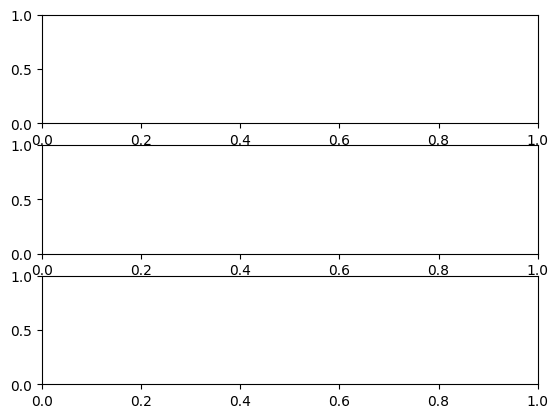

In [60]:
# same color for 10 * [4 * 25].mean('chain', 'draw') = 1000? for observed data and
fig, ax = plt.subplots(3, 1)
sbc.observed_data['prey_obs'].plot(hue = 'prior_draw', row = 'region', x = 'time', ax = ax,)
sbc.posterior_predictive['prey_obs'].mean(['draw', 'chain']).plot(hue = 'prior_draw', row = 'region', x = 'time', ax = ax,)

In [52]:
sbc

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [51]:
sbc.observed_data.dims

Frozen({'prior_draw': 10, 'time': 40, 'region': 3})

In [50]:
sbc.posterior_predictive.dims

Frozen({'chain': 4, 'draw': 25, 'prey_obs_post_dim_0': 40, 'prey_obs_post_dim_1': 3, 'prior_draws': 10, 'predator_obs_post_dim_0': 40, 'predator_obs_post_dim_1': 3})

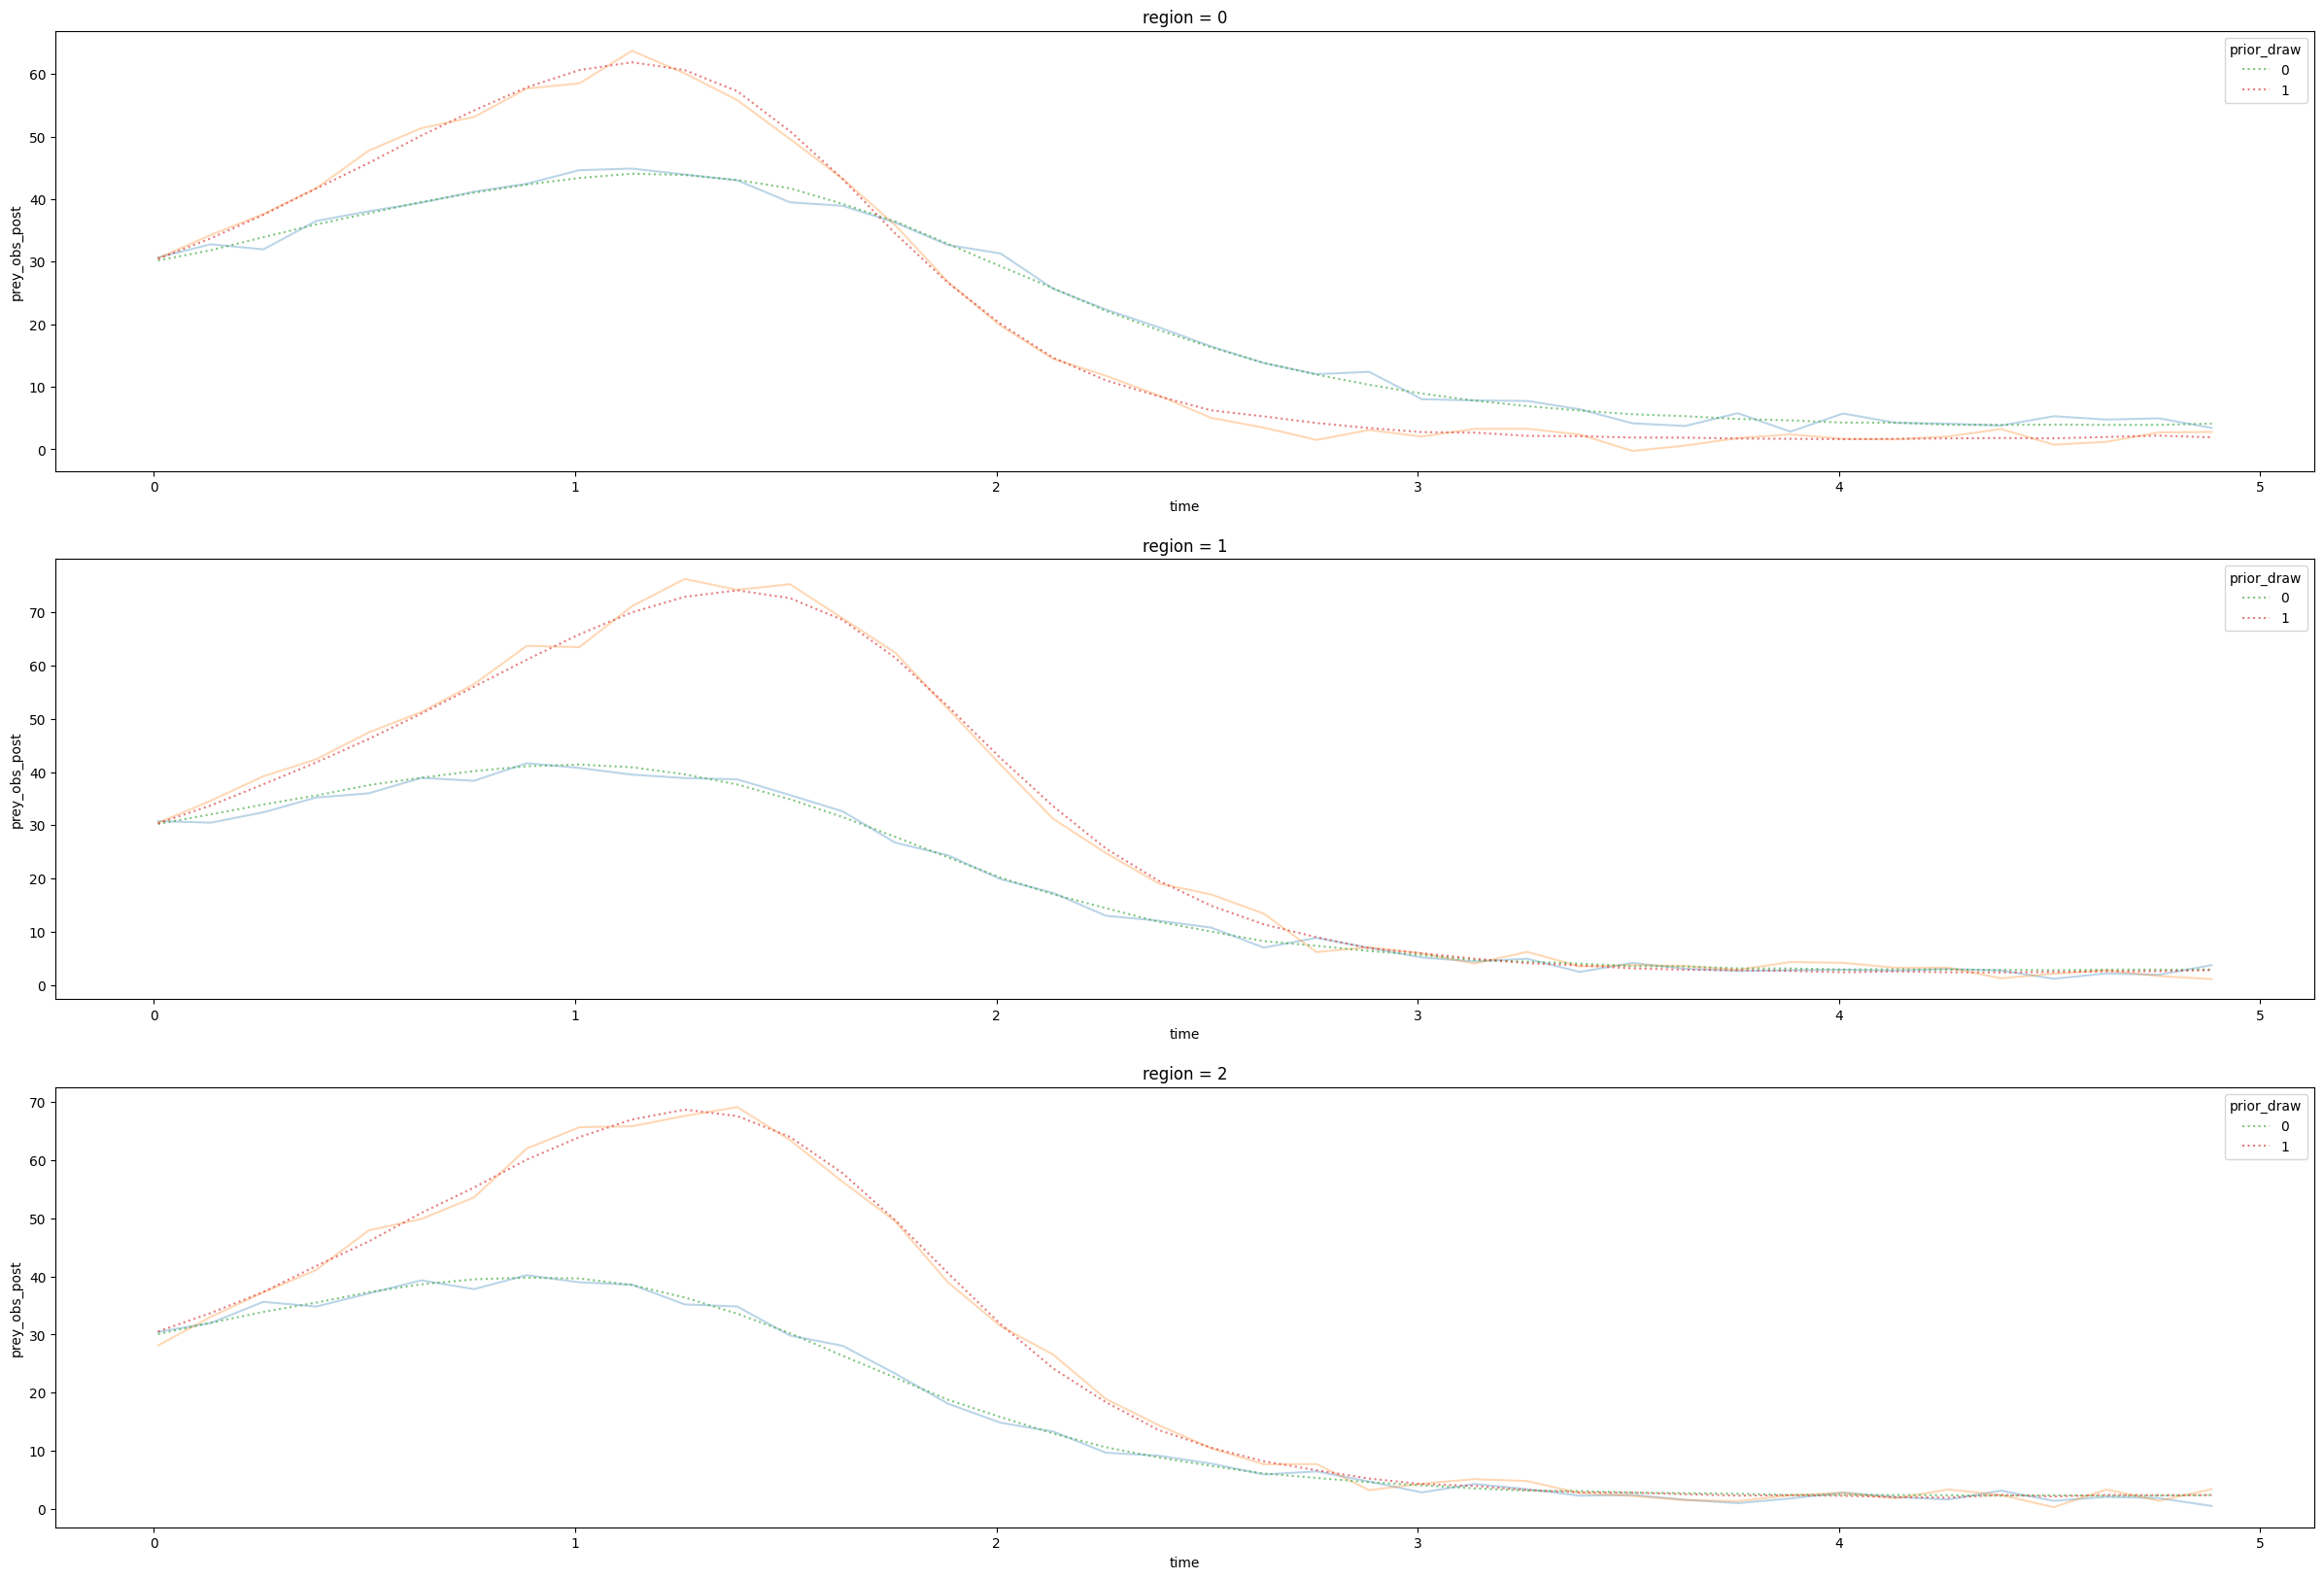

In [79]:
fig, axes = plt.subplots(precision['R'],1, figsize = (30, 20))
for r, ax in zip(range(precision['R']), axes):
    sbc_aux = sbc.sel(region = r)
    sbc_aux.observed_data['prey_obs'].plot(hue = 'prior_draw',x = 'time', ax = ax, alpha= .3)
    sbc_aux.posterior_predictive['prey_obs_post'].mean(['draw', 'chain']).plot(hue = 'prior_draw', x = 'time', ax = ax, alpha= .6, linestyle = 'dotted')

In [82]:
sbc.posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [69]:
model_name2 = "prey_predator_S10N40Q2R3"
sbc2 = az.from_netcdf(f"data/{model_name2}/sbc_2est_mnoise0.nc")

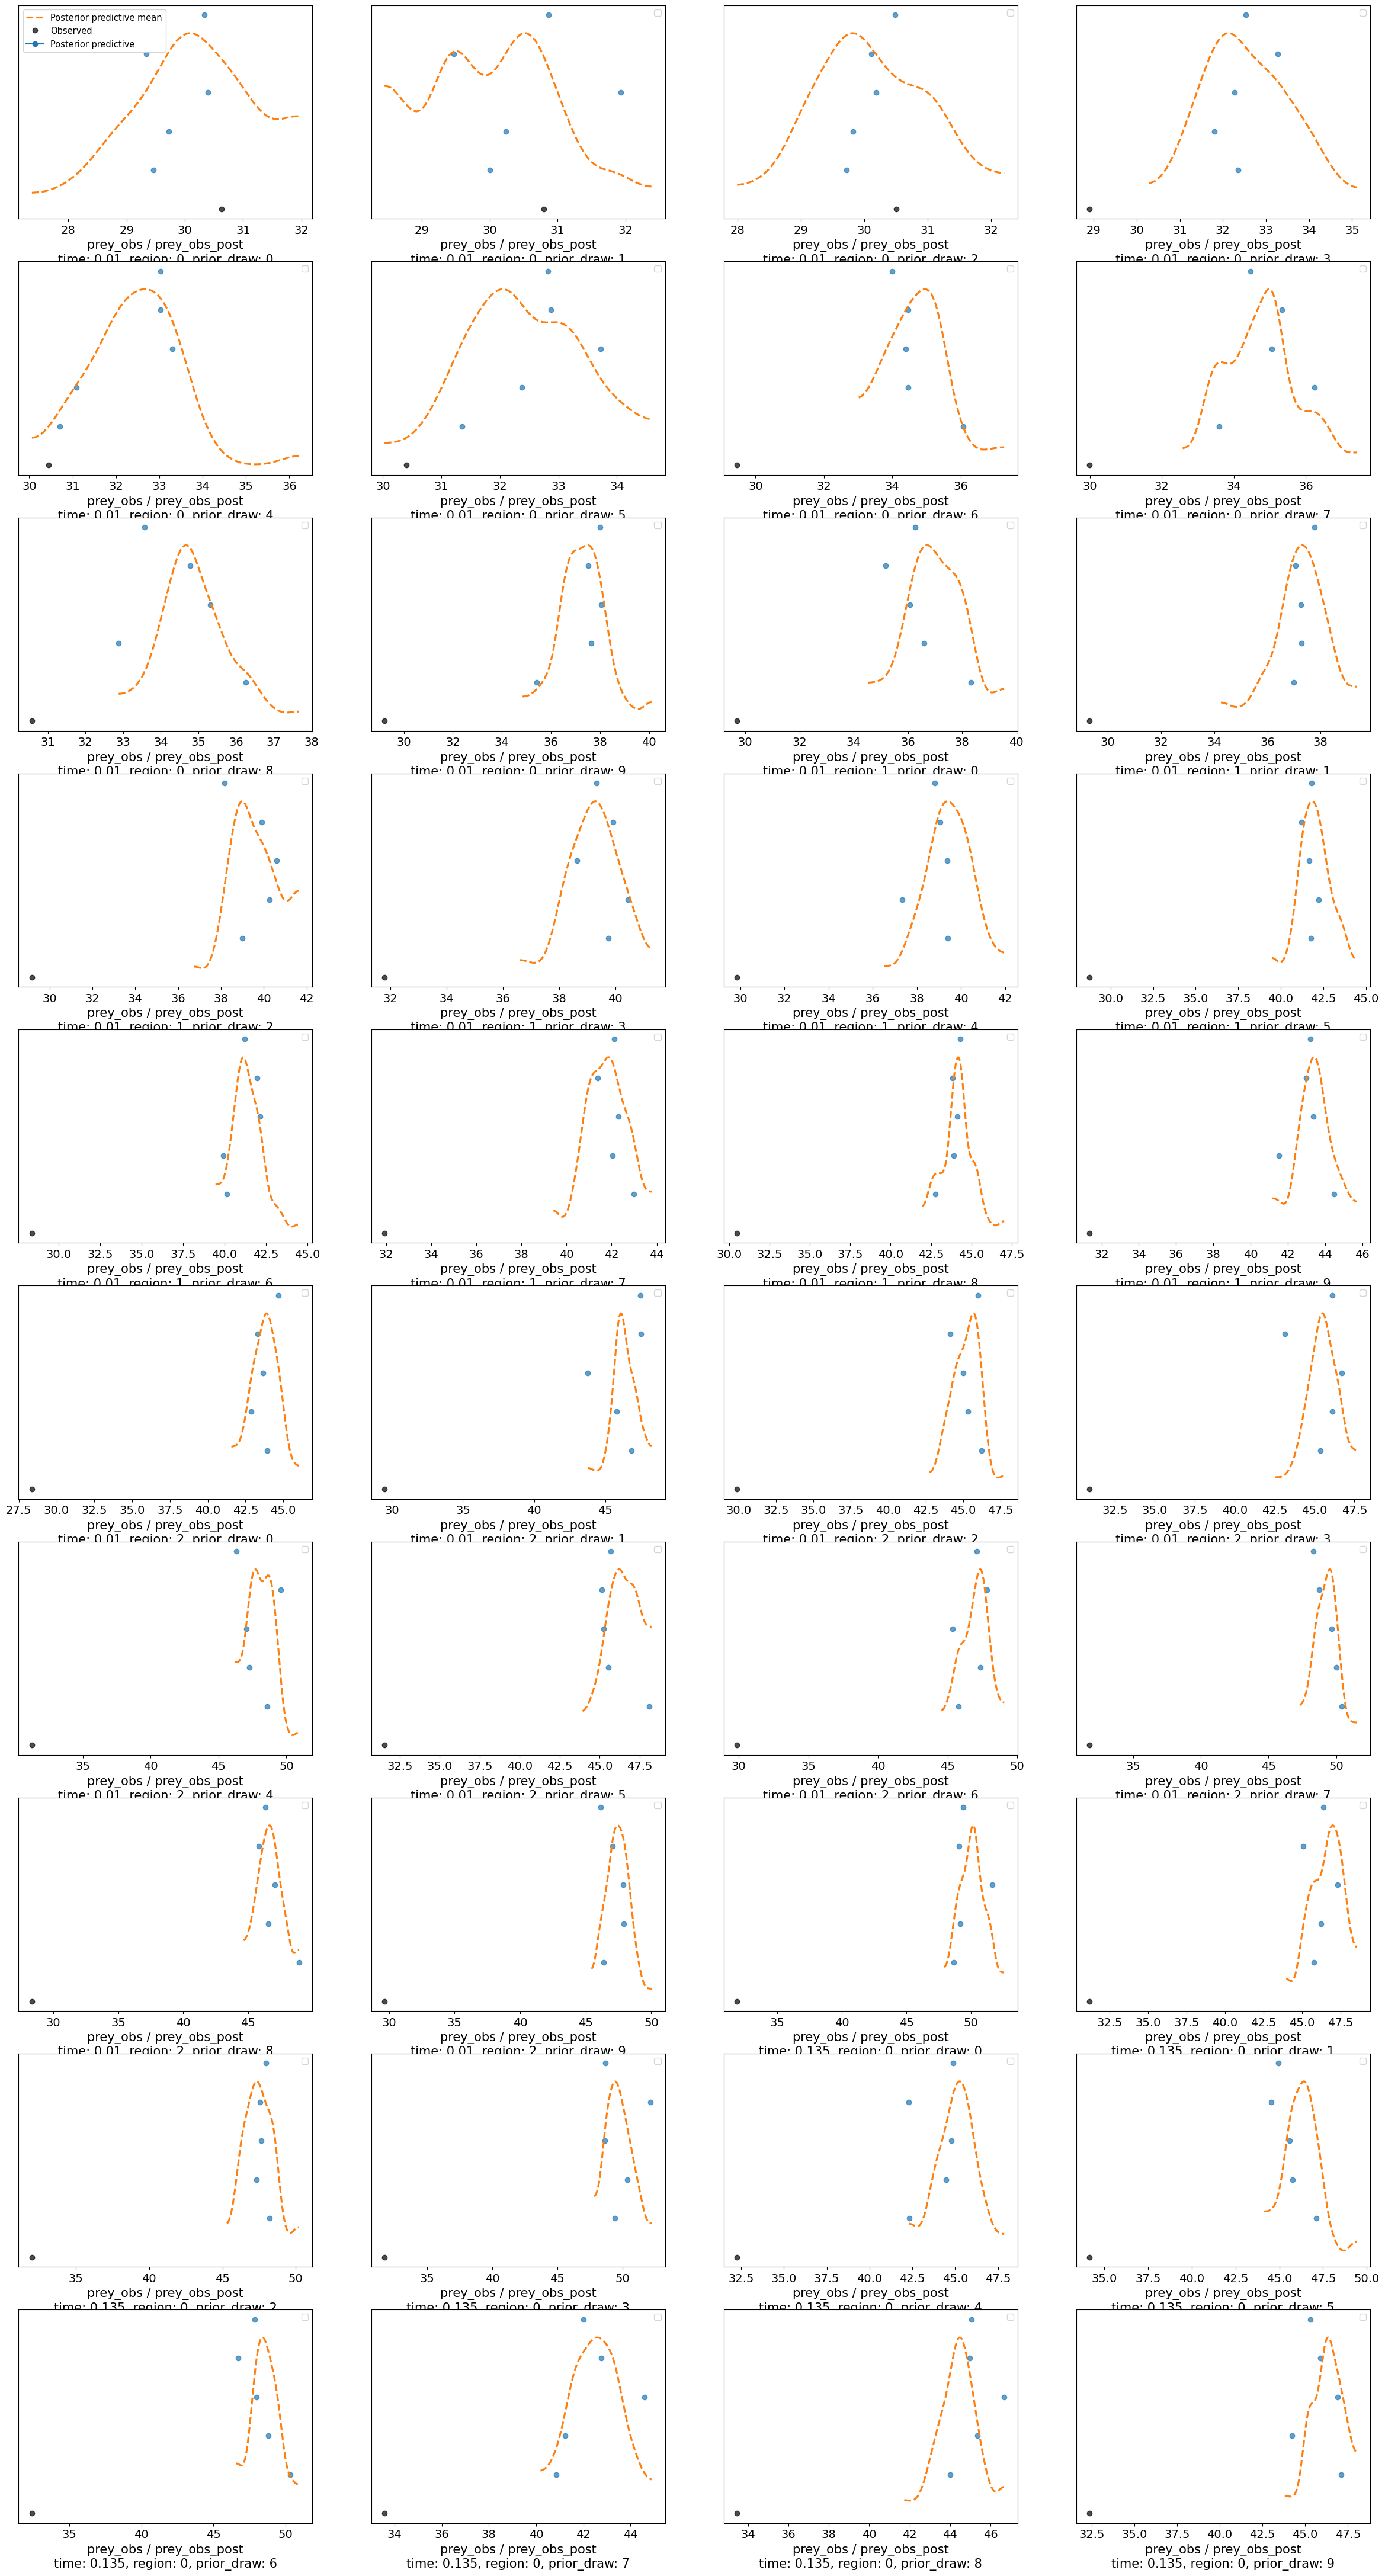

In [33]:
"az.plot_ppc(sbc, data_pairs={'predator_obs':'predator_obs_post', 'prey_obs':'prey_obs_post'}, flatten = [], kind = 'scatter', labeller=az.labels.DimCoordLabeller());
# labeller shows xlabel
# kind = scatter (few points)

In [23]:
sbc_precision = sbc

def save_fig(model_name, is_draws2data, plot_name):
    plot_path = get_plot_path(model_name)
    fig_name = f"{plot_path}/{model_name}_{plot_name}"
    if is_draws2data:
        fig_name = fig_name + "_draws2data"
    else:
        fig_name = fig_name + "_data2draws"
    plt.savefig(f"{fig_name}.png")
    return
def plot_qoi(sbc_precision, setting, precision, idata_kwargs, model_name):
    data_path = get_data_path(model_name)
    #sbc = xr.open_dataset(f"{data_path}/sbc.nc")
    sbc = sbc_precision
    figsize = (30, 15)
    # TODO @Oriol how to replace to_dataframe?  values?
    if precision['R'] > 1:
        sbc.observed_data.to_dataframe()[idata_kwargs['prior_predictive']].plot(by='region', figsize = figsize)
    else:
        sbc.observed_data.to_dataframe()[idata_kwargs['prior_predictive']].plot(figsize = figsize)

    save_fig(model_name, True, "data_obs")
    plt.clf()

    est_param_names = setting['est_param_names']

    az.plot_posterior(sbc, var_names=est_param_names, figsize = figsize)
    save_fig(model_name, False, "posterior")
    plt.clf()

    az.plot_trace(sbc, var_names=est_param_names, divergences=True, compact=True, figsize = figsize)
    save_fig(model_name, False, "trace")
    plt.clf()

    data_pairs = dict()
    for obs_name in idata_kwargs['prior_predictive']:
        data_pairs[obs_name] = f'{obs_name}_post'
    az.plot_ppc(sbc, data_pairs=data_pairs, figsize = figsize)

    # joint: pair plot
    az.plot_pair(sbc, var_names=est_param_names, divergences=True, figsize = figsize)
    save_fig(model_name, False, "pair")
    plt.clf()

    # rank plot with loglik
    fig, axes = plt.subplots(1, len(est_param_names))
    az.plot_rank(sbc, var_names=est_param_names, ax=axes, figsize = figsize)
    save_fig(model_name, False, "rank")
    plt.clf()
    return

In [50]:
sbc.prior.transpose(sbc.prior.dims)

TypeError: unhashable type: 'Frozen'

In [51]:
sbc.prior.transpose(sbc.prior.dims.keys())

TypeError: unhashable type: 'KeysView'

In [14]:
import logging
plot_sbc_histograms(sbc_stack.posterior.stacked_variables.values, sbc_stack.prior.stacked_variables.values)

+++++++++++++++ 10 100


NameError: name 'logging' is not defined

In [42]:
plot_sbc_histograms(sbc_stack.posterior.variable.values, sbc_stack.prior.variable.values)

ShapeError: post_samples should be a 3-dimensional array, with the first dimension being the number of (simulated) data sets, the second dimension being the number of posterior draws per data set, and the third dimension being the number of parameters (marginal distributions), but your input has dimensions 1

In [ ]:
##TODO @Oriol could we infer `hier_est_param_name` from .nc?
# TODO @Oriol how to replace to_dataframe?  values? plot_qoi

In [13]:
def plot_sbc_histograms(post_samples, prior_samples, param_names=None, fig_size=None, num_bins=None,
                        binomial_interval=0.99, label_fontsize=14, title_fontsize=16, hist_color='#a34f4f'):
    """Creates and plots publication-ready histograms of rank statistics for simulation-based calibration
    (SBC) checks according to:

    [1] Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018).
    Validating Bayesian inference algorithms with simulation-based calibration.
    arXiv preprint arXiv:1804.06788.

    Any deviation from uniformity indicates miscalibration and thus poor convergence
    of the networks or poor combination between generative model / networks.

    Parameters
    ----------
    post_samples      : np.ndarray of shape (n_data_sets, n_post_draws, n_params)
        The posterior draws obtained from n_data_sets
    prior_samples     : np.ndarray of shape (n_data_sets, n_params)
        The prior draws obtained for generating n_data_sets
    param_names       : list or None, optional, default: None
        The parameter names for nice plot titles. Inferred if None
    fig_size          : tuple or None, optional, default : None
        The figure size passed to the matplotlib constructor. Inferred if None
    num_bins          : int, optional, default: 10
        The number of bins to use for each marginal histogram
    binomial_interval : float in (0, 1), optional, default: 0.95
        The width of the confidence interval for the binomial distribution
    label_fontsize    : int, optional, default: 14
        The font size of the y-label text
    title_fontsize    : int, optional, default: 16
        The font size of the title text
    hist_color        : str, optional, default '#a34f4f'
        The color to use for the histogram body

    Returns
    -------
    f : plt.Figure - the figure instance for optional saving

    Raises
    ------
    ShapeError
        If there is a deviation form the expected shapes of `post_samples` and `prior_samples`.
    """

    # Sanity check
    check_posterior_prior_shapes(post_samples, prior_samples)

    # Determine the ratio of simulations to prior draws
    n_sim, n_draws, n_params = post_samples.shape
    print("+++++++++++++++", n_sim, n_draws)
    ratio = int(n_sim / n_draws)

    # Log a warning if N/B ratio recommended by Talts et al. (2018) < 20
    if ratio < 20:
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logger.info(f'The ratio of simulations / posterior draws should be > 20 ' +
                    f'for reliable variance reduction, but your ratio is {ratio}.\
                    Confidence intervals might be unreliable!')

    # Set n_bins automatically, if nothing provided
    if num_bins is None:
        num_bins = int(ratio / 2)
        # Attempt a fix if a single bin is determined so plot still makes sense
        if num_bins == 1:
            num_bins = 5

    # Determine n params and param names if None given
    if param_names is None:
        param_names = [f'$p_{i}$' for i in range(1, n_params + 1)]

    # Determine n_subplots dynamically
    n_row = int(np.ceil(n_params / 6))
    n_col = int(np.ceil(n_params / n_row))

    # Initialize figure
    if fig_size is None:
        fig_size = (int(5 * n_col), int(5 * n_row))
    f, axarr = plt.subplots(n_row, n_col, figsize=fig_size)

    # Compute ranks (using broadcasting)
    ranks = np.sum(post_samples < prior_samples[:, np.newaxis, :], axis=1)

    # Compute confidence interval and mean
    N = int(prior_samples.shape[0])
    # uniform distribution expected -> for all bins: equal probability
    # p = 1 / num_bins that a rank lands in that bin
    endpoints = binom.interval(binomial_interval, N, 1 / num_bins)
    mean = N / num_bins  # corresponds to binom.mean(N, 1 / num_bins)

    # Plot marginal histograms in a loop
    if n_row > 1:
        ax = axarr.flat
    else:
        ax = axarr
    for j in range(len(param_names)):
        ax[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        ax[j].axhline(mean, color='gray', zorder=0, alpha=0.5)
        sns.histplot(ranks[:, j], kde=False, ax=ax[j], color=hist_color, bins=num_bins, alpha=0.95)
        ax[j].set_title(param_names[j], fontsize=title_fontsize)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['top'].set_visible(False)
        ax[j].set_xlabel('Rank statistic', fontsize=label_fontsize)
        ax[j].get_yaxis().set_ticks([])
        ax[j].set_ylabel('')
    f.tight_layout()
    plt.savefig(f)
    return f

def check_posterior_prior_shapes(post_samples, prior_samples):
    """Checks requirements for the shapes of posterior and prior draws as
    necessitated by most diagnostic functions.

    Parameters
    ----------
    post_samples      : np.ndarray of shape (n_data_sets, n_post_draws, n_params)
        The posterior draws obtained from n_data_sets
    prior_samples     : np.ndarray of shape (n_data_sets, n_params)
        The prior draws obtained for generating n_data_sets

    Raises
    ------
    ShapeError
        If there is a deviation form the expected shapes of `post_samples` and `prior_samples`.
    """

    if len(post_samples.shape) != 3:
        raise ShapeError(f'post_samples should be a 3-dimensional array, with the ' +
                         f'first dimension being the number of (simulated) data sets, ' +
                         f'the second dimension being the number of posterior draws per data set, ' +
                         f'and the third dimension being the number of parameters (marginal distributions), ' +
                         f'but your input has dimensions {len(post_samples.shape)}')
    elif len(prior_samples.shape) != 2:
        raise ShapeError(f'prior_samples should be a 2-dimensional array, with the ' +
                         f'first dimension being the number of (simulated) data sets / prior draws ' +
                         f'and the second dimension being the number of parameters (marginal distributions), ' +
                         f'but your input has dimensions {len(prior_samples.shape)}')
    elif post_samples.shape[0] != prior_samples.shape[0]:
        raise ShapeError(f'The number of elements over the first dimension of post_samples and prior_samples' +
                         f'should match, but post_samples has {post_samples.shape[0]} and prior_samples has ' +
                         f'{prior_samples.shape[0]} elements, respectively.')
    elif post_samples.shape[-1] != prior_samples.shape[-1]:
        raise ShapeError(f'The number of elements over the last dimension of post_samples and prior_samples' +
                         f'should match, but post_samples has {post_samples.shape[1]} and prior_samples has ' +
                         f'{prior_samples.shape[-1]} elements, respectively.')

In [44]:
sbc_stack.posterior.stacked_variables.values

array([[[ 0.691784 ,  0.0467613,  0.887616 , ...,  4.19848  ,
         12.9336   ,  4.20903  ],
        [ 0.69866  ,  0.0463682,  1.04986  , ...,  4.20939  ,
         13.0434   ,  4.22057  ],
        [ 0.694396 ,  0.046896 ,  0.90227  , ...,  4.15189  ,
         12.8955   ,  4.16468  ],
        ...,
        [ 0.696119 ,  0.0465593,  0.993415 , ...,  4.19716  ,
         12.9898   ,  4.20844  ],
        [ 0.697152 ,  0.0464961,  1.05751  , ...,  4.19952  ,
         13.0075   ,  4.21086  ],
        [ 0.692993 ,  0.0465565,  0.912491 , ...,  4.22499  ,
         12.9913   ,  4.23467  ]],

       [[ 0.741901 ,  0.0447077,  1.2055   , ...,  4.12474  ,
         13.49     ,  4.14583  ],
        [ 0.742084 ,  0.0449627,  1.14138  , ...,  4.07977  ,
         13.4137   ,  4.10274  ],
        [ 0.747976 ,  0.0446619,  1.11513  , ...,  4.08032  ,
         13.4943   ,  4.10413  ],
        ...,
        [ 0.749779 ,  0.0443957,  1.06734  , ...,  4.10987  ,
         13.5714   ,  4.13272  ],
        [ 0.

In [30]:
sbc.observed_data.to_dataframe().plot()

AttributeError: 'InferenceData' object has no attribute 'observed_data'

Posterior is very tight without much uncertainty

array([[<AxesSubplot: title={'center': 'inventory_adjustment_time\n0, 0'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n0, 1'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n1, 0'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n1, 1'}>],
       [<AxesSubplot: title={'center': 'inventory_adjustment_time\n2, 0'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n2, 1'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n3, 0'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n3, 1'}>],
       [<AxesSubplot: title={'center': 'inventory_adjustment_time\n4, 0'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n4, 1'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n5, 0'}>,
        <AxesSubplot: title={'center': 'inventory_adjustment_time\n5, 1'}>],
       [<AxesSubplot: title={'center': 'inventory_adjustment_time\n6, 0'}>,
        <

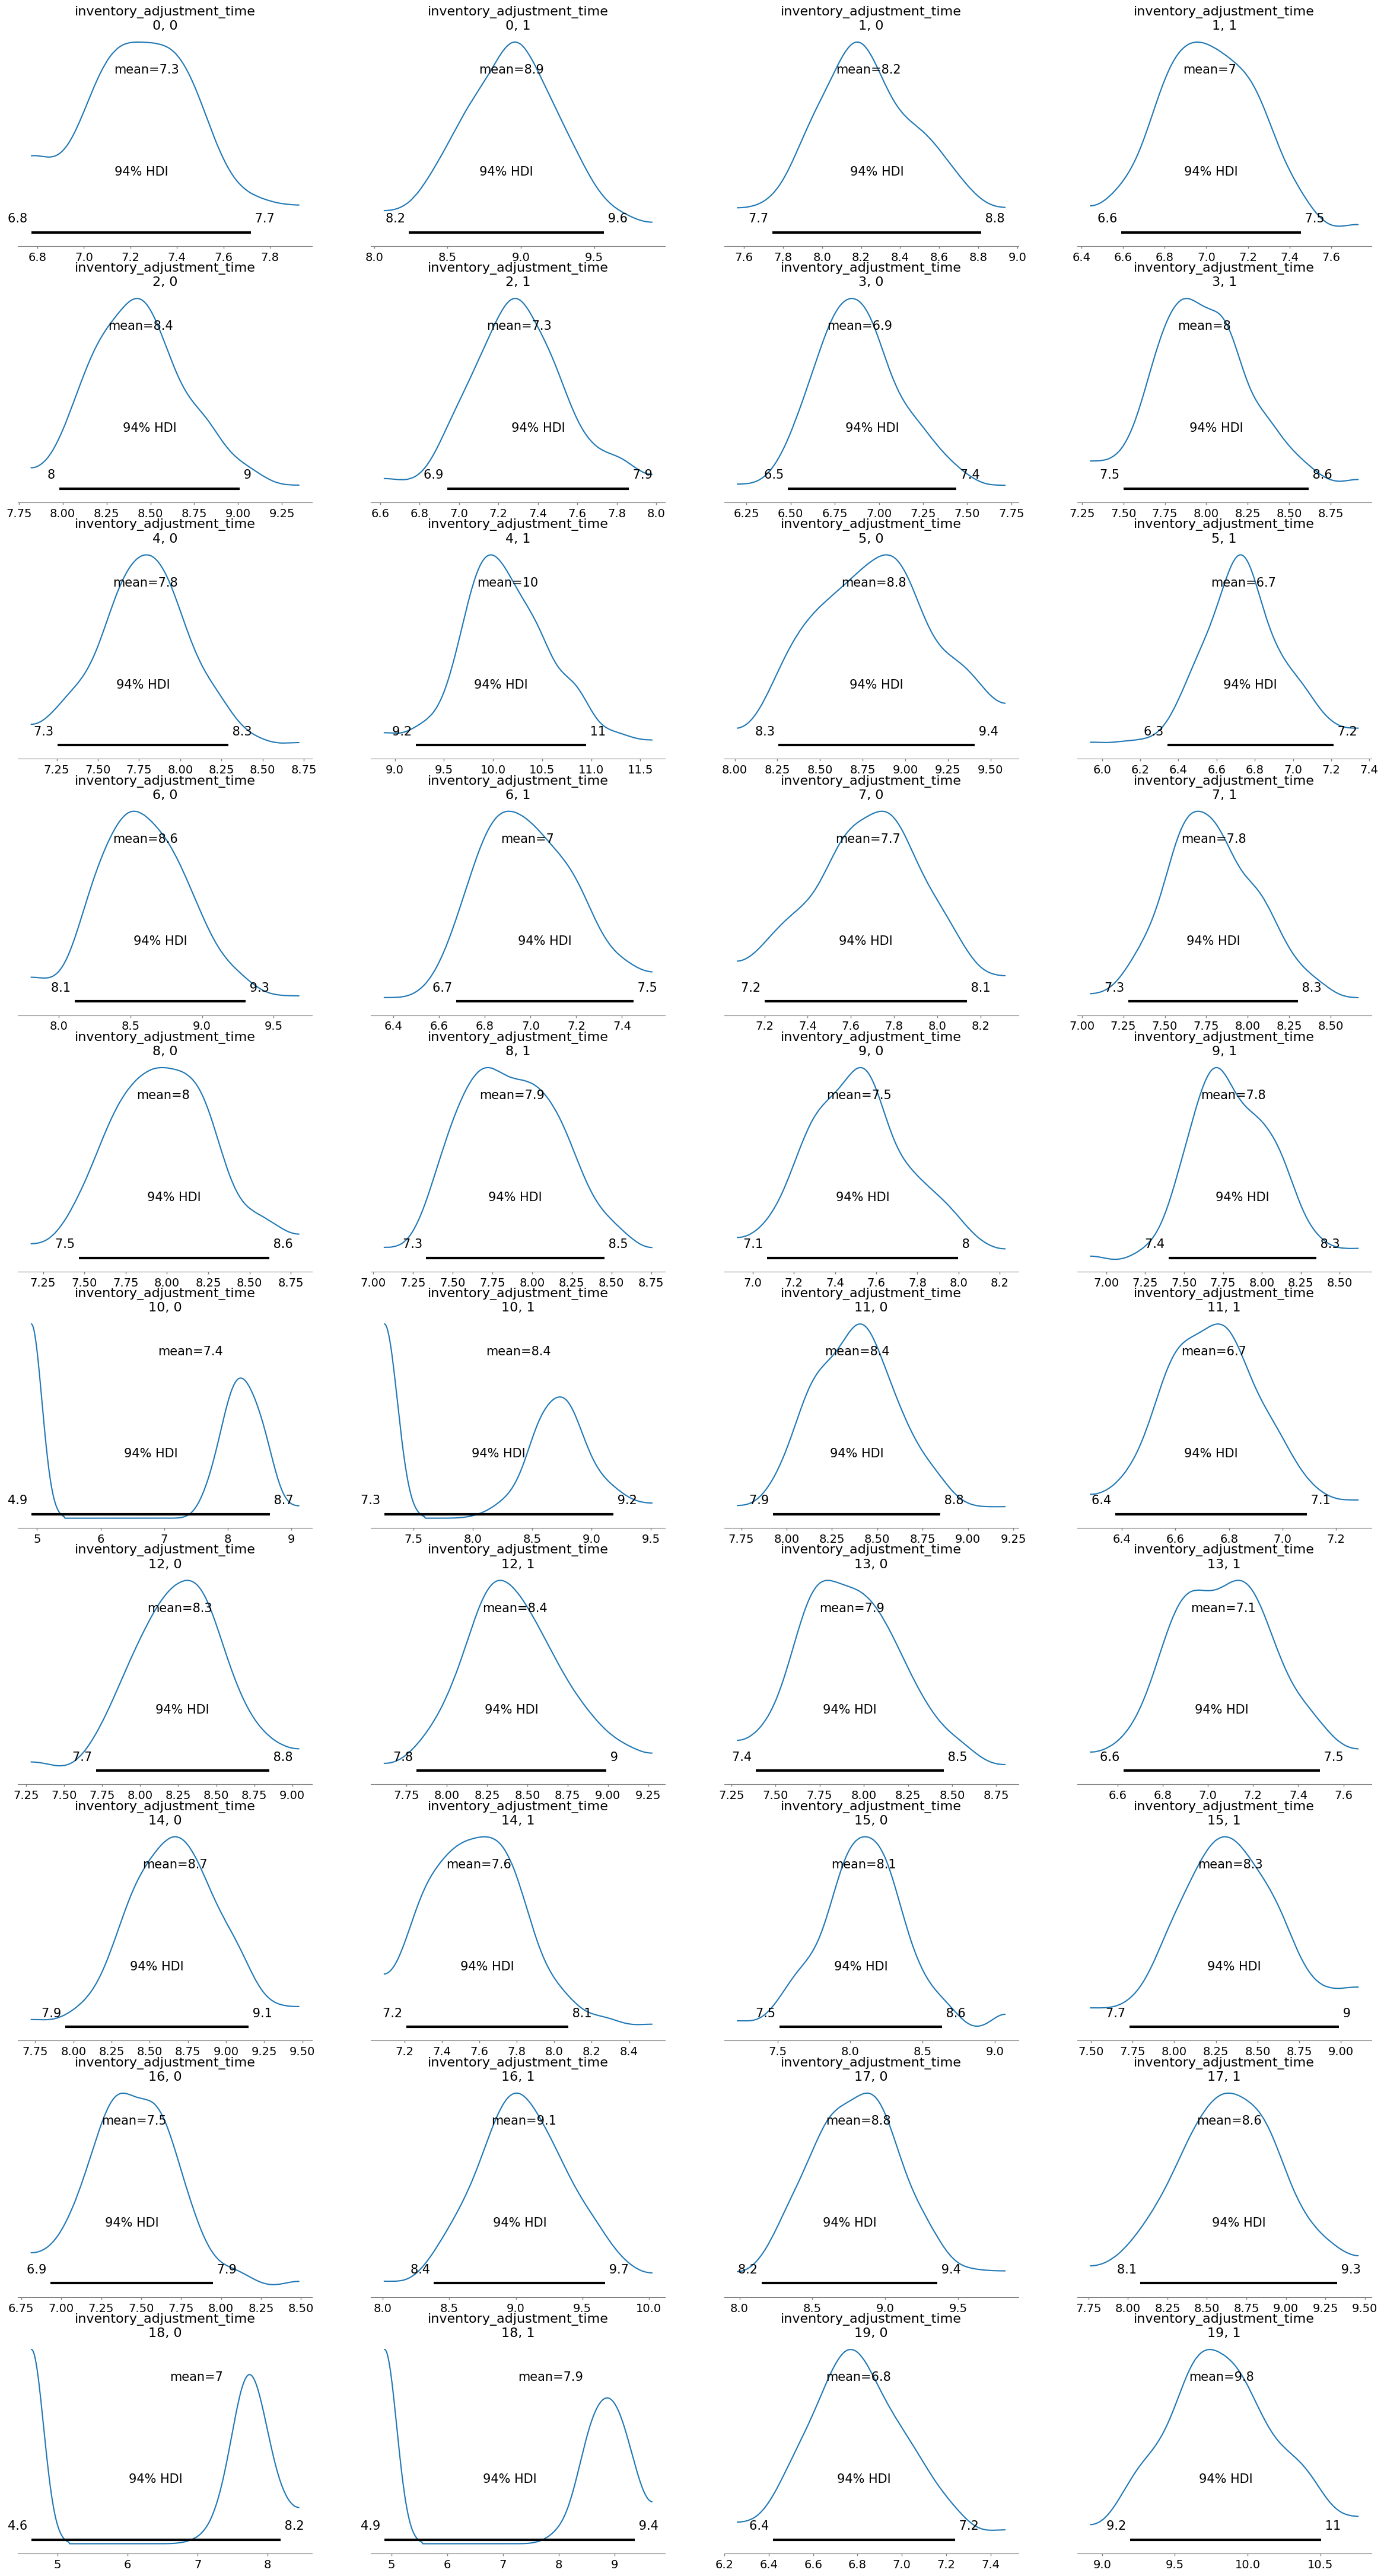

In [6]:
az.plot_posterior(sbc, var_names=setting['est_param_names'])

In [3]:
sbc.posterior.inventory_adjustment_time.shape

NameError: name 'sbc' is not defined

In [18]:
sbc.prior.inventory_adjustment_time.shape

(2, 20)

In [19]:
sbc.prior.inventory_adjustment_time # inventory_adj_time_hier:2, prior_draw:20

<xarray.DataArray 'inventory_adjustment_time' (
                                               inventory_adjustment_time_dim_0: 2,
                                               prior_draw: 20)>
[40 values with dtype=float64]
Coordinates:
    chain                            (prior_draw) int64 ...
    draw                             (prior_draw) int64 ...
  * inventory_adjustment_time_dim_0  (inventory_adjustment_time_dim_0) int64 0 1
Dimensions without coordinates: prior_draw

In [16]:
sbc.posterior.inventory_adjustment_time # prior_draws:20, chain:4, draw:50, inventory_adj_time_hier:2

<xarray.DataArray 'inventory_adjustment_time' (prior_draws: 20, chain: 4,
                                               draw: 50,
                                               inventory_adjustment_time_dim_0: 2)>
array([[[[ 7.55509,  9.24527],
         ...,
         [ 7.52593,  8.64721]],

        ...,

        [[ 7.41978,  9.14074],
         ...,
         [ 7.12444,  8.70053]]],


       ...,


       [[[ 6.67999,  9.88456],
         ...,
         [ 7.4403 , 10.3797 ]],

        ...,

        [[ 6.86139,  9.37533],
         ...,
         [ 6.81199, 10.5458 ]]]])
Coordinates:
  * chain                            (chain) int64 0 1 2 3
  * draw                             (draw) int64 0 1 2 3 4 5 ... 45 46 47 48 49
  * inventory_adjustment_time_dim_0  (inventory_adjustment_time_dim_0) int64 0 1
Dimensions without coordinates: prior_draws

In [1]:
model_name = "prey_predator_S10N40Q2R3"
sbc_pp = az.from_netcdf(f"data/{model_name}/sbc_2est_mnoise0.nc")

NameError: name 'az' is not defined

In [5]:
plot_sbc_histograms(sbc.posterior.inventory_adjustment_time, sbc.prior.inventory_adjustment_time, param_names = "inventory_adjustment_time")

# sbc.prior.inventory_adjustment_time # inventory_adj_time_hier:2, prior_draw:20

# sbc.posterior.inventory_adjustment_time # prior_draws:20, chain:4, draw:50, inventory_adj_time_hier:2

ShapeError: post_samples should be a 3-dimensional array, with the first dimension being the number of (simulated) data sets, the second dimension being the number of posterior draws per data set, and the third dimension being the number of parameters (marginal distributions), but your input has dimensions 4

In [22]:
sbc.prior.transpose(sbc.prior.dims.keys())

TypeError: unhashable type: 'KeysView'

KeysView(Frozen({'prior_draw': 20, 'inventory_adjustment_time_dim_0': 2, 'backlog_dim_0': 10, 'backlog_dim_1': 2, 'expected_order_rate_dim_0': 10, 'expected_order_rate_dim_1': 2, 'inventory_dim_0': 10, 'inventory_dim_1': 2, 'time': 10, 'production_rate_stocked_dim_1': 2, 'production_start_rate_stocked_dim_1': 2, 'work_in_process_inventory_dim_0': 10, 'work_in_process_inventory_dim_1': 2}))

In [6]:
sbc.prior.inventory_adjustment_time.view

<xarray.DataArray 'inventory_adjustment_time' (
                                               inventory_adjustment_time_dim_0: 2,
                                               prior_draw: 20)>
[40 values with dtype=float64]
Coordinates:
    chain                            (prior_draw) int64 ...
    draw                             (prior_draw) int64 ...
  * inventory_adjustment_time_dim_0  (inventory_adjustment_time_dim_0) int64 0 1
Dimensions without coordinates: prior_draw

The [forest plot](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) shows chains are stuck. Generally, each chain has different values, so plot_posterior that combines gives a semblance of kde, but for this model, each chain returns always the same exact value.

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

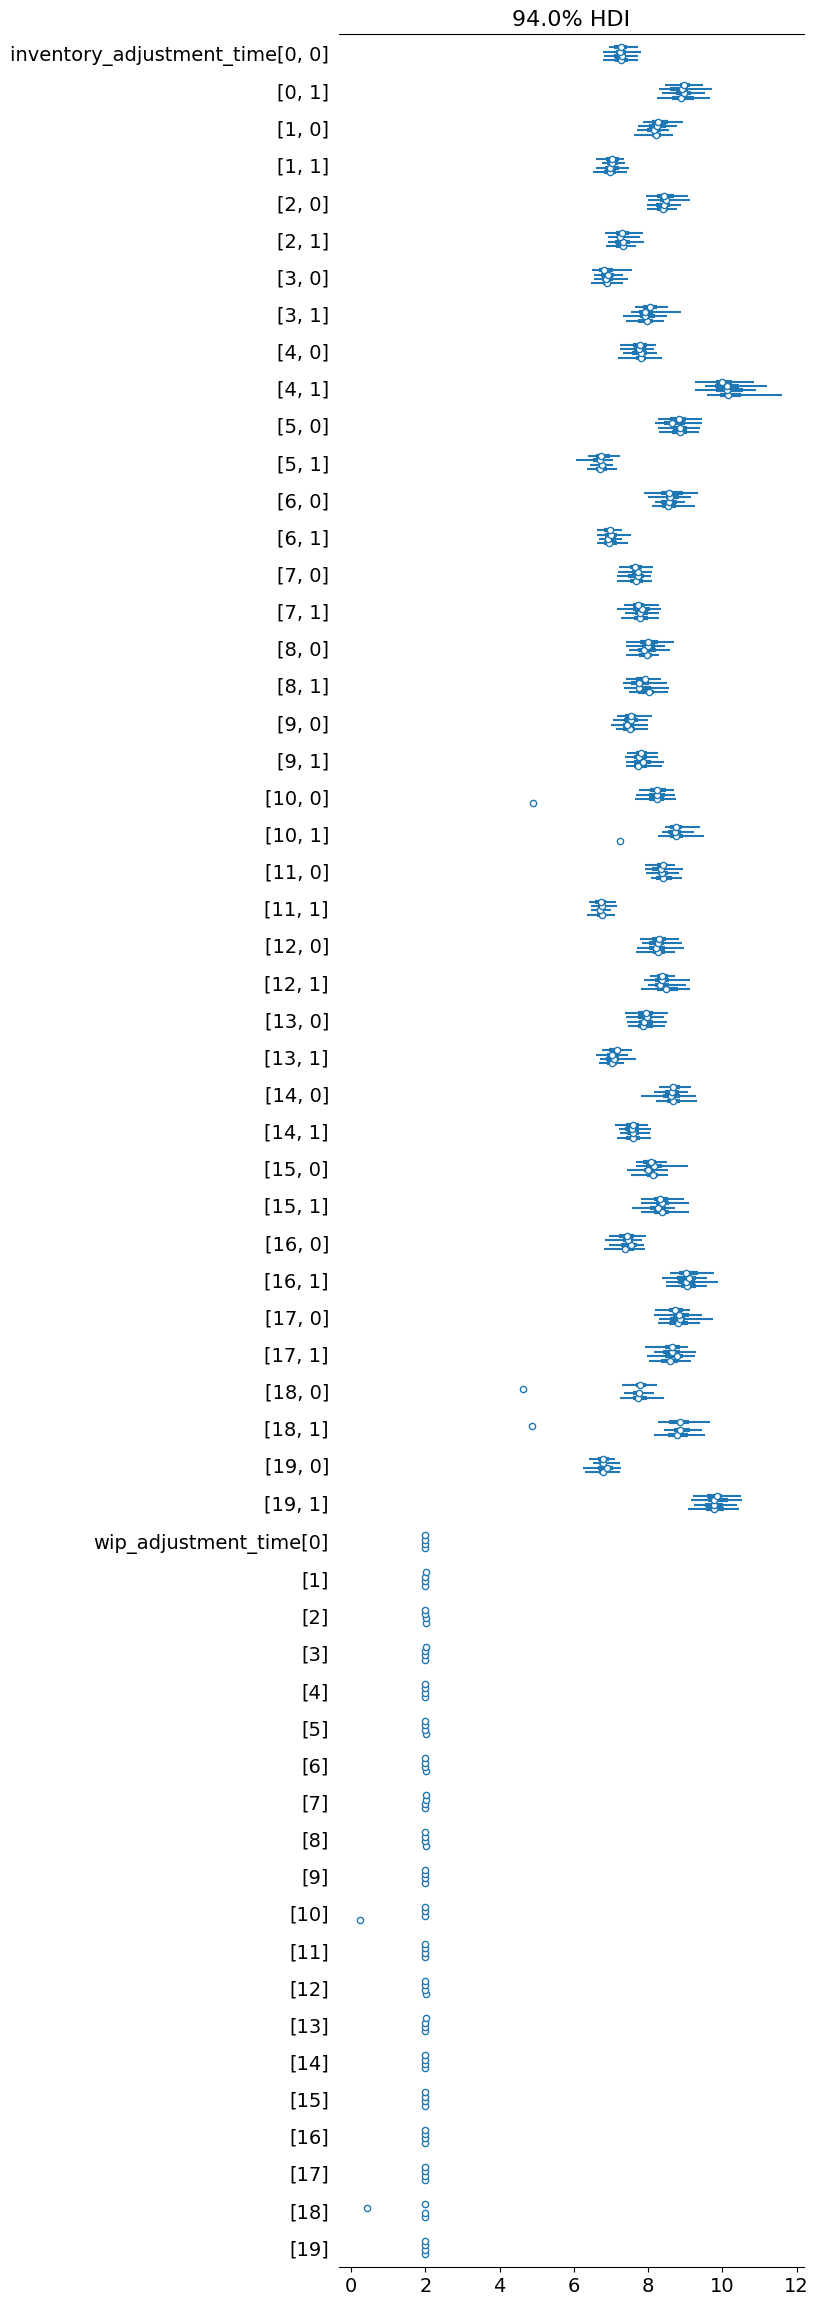

In [7]:
az.plot_forest(sbc, var_names = setting['est_param_names'])

summary function returns mean, sd, credible interval for estimated parameter and target simulated vector. mcse, effective sample size (ess), r_hat tells quality of each variables' sample. Refer to [Stan manual](https://mc-stan.org/docs/reference-manual/effective-sample-size.html) for ess details. From large number of r_hat, the covergence of four chains are not good which is verified in more detail below. 1.2 is the usual threshold for r_hat.

In [8]:
az.summary(sbc.posterior[setting['est_param_names']])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"inventory_adjustment_time[0, 0]",7.994,0.714,6.804,9.311,0.040,0.028,332.0,98.0,1.01
"inventory_adjustment_time[0, 1]",8.030,0.837,6.526,9.633,0.055,0.039,234.0,94.0,1.01
wip_adjustment_time[0],1.998,0.020,1.959,2.037,0.001,0.001,325.0,135.0,1.03


In [10]:
az.summary(sbc.posterior['m_noise_scale'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m_noise_scale[0],10502.206,694.806,9115.98,11557.1,42.687,30.702,265.0,137.0,1.01


The PPC (prior/poseterior predictive check) plot is a standard way for Bayesian checking. It serves complementary role with simulation-based calibration (SBC). Two checks happen in different space: PPC in observation space as time series, SBC in parameter space as rank comparison between the ground truth and retrieved estimated samples. From the plot, posterior predictive's negative values is the most problematic which was expected as the currrent version uses normal likelihood. Changing this to lognoraml or negative binomial can solve this problem, but lognormal has thicker tail creating difficult posterior geometry and negative binomial need transformation to integer value which is known to be not accurate.

new plot that compares against time is needed for dynamic models. posterior predictive is quite different from general bayse models.

array([<AxesSubplot: xlabel='inventory_obs / inventory_obs_post'>,
       <AxesSubplot: xlabel='work_in_process_inventory_obs / work_in_process_inventory_obs_post'>],
      dtype=object)

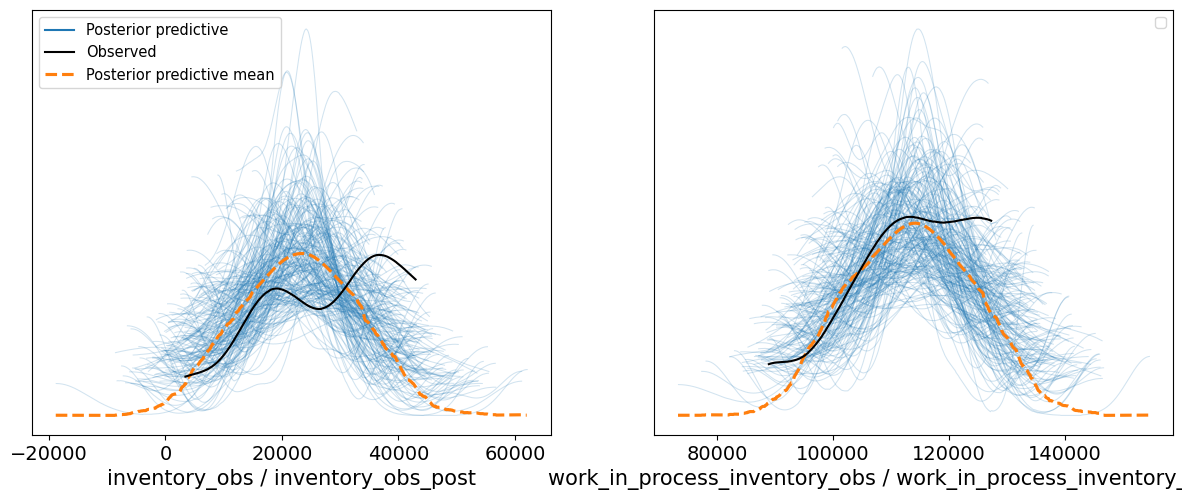

In [9]:
data_pairs = dict()
for obs_name in output_format['prior_predictive']:
    data_pairs[obs_name] = f'{obs_name}_post'
az.plot_ppc(sbc, data_pairs = data_pairs)

# loglikliehood plots

# Appendix

## model

In [11]:
print(CmdStanModel(stan_file=f"stan_files/{model.model_name}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{model.model_name}/data2draws.stan").code())

functions{
  #include functions.stan
}

data{
    int <lower=0> S;  // # of draws from prior 
    int <lower=0> M;  // # of draws from posterior (# of chains * # of draws from each chain)
    int <lower=0> N;  // # of observation
    int <lower=0> Q;  // # of target_simulated_stock and obs_vectors 
    int <lower=0> R;  // # of subgroups for hierarchical Bayes 
    real <lower=0> time_step;
    array[N] real integration_times;
    vector[10] customer_order_rate;
}

transformed data {
    real initial_time = 0.0;

    // Initial ODE values
    real backlog__init = dataFunc__customer_order_rate(0, time_step) * 2;
    real expected_order_rate__init = dataFunc__customer_order_rate(0, time_step);
    real inventory__init = 2 + 2 * dataFunc__customer_order_rate(0, time_step);
    real work_in_process_inventory__init = 8 * fmax(0, dataFunc__customer_order_rate(0, time_step) + (2 + 2 * dataFunc__customer_order_rate(0, time_step) - 2 + 2 * dataFunc__customer_order_rate(0, time_step)) / 8);

   